# Tutorial 1: Entanglement Forging VQE for the H₂ molecule

In this tutorial, we apply Entanglement Forging to compute the energy of a hydrogen molecule ($\mathrm{H}_2$). 

For comparison, you may wish to review how regular VQE is used to solve the same problem [here](https://github.com/Qiskit/qiskit-nature/blob/stable/0.4/docs/tutorials/03_ground_state_solvers.ipynb). 

### Import the relevant modules

We begin by importing the relevant modules, including from `qiskit` and `qiskit-nature`.  From the `circuit_knitting_toolbox`, we import `EntanglementForgingAnsatz` and `EntanglementForgingGroundStateSolver`.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers import (
    GroundStateEigensolver,
    NumPyMinimumEigensolverFactory,
)

from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingAnsatz,
    EntanglementForgingGroundStateSolver,
)

### Instantiate the `ElectronicStructureProblem`

Next, we set up the $\mathrm{H}_2$ molecule, specify the driver and converter, and instantiate an  `ElectronicStructureProblem`, just like is done in the [Qiskit Nature VQE tutorial](https://github.com/Qiskit/qiskit-nature/blob/stable/0.4/docs/tutorials/03_ground_state_solvers.ipynb).

In [2]:
molecule = Molecule(
    geometry=[
        ("H", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 0.735]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")
problem = ElectronicStructureProblem(driver)
converter = QubitConverter(JordanWignerMapper())

### Compute the classical result

For comparison, we also use `numpy` to compute the classical result. 

In [3]:
solver = GroundStateEigensolver(
    converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False)
)

result = solver.solve(problem)
classical_energy = result.total_energies[0]

print("Classical energy = ", classical_energy)

Classical energy =  -1.1373060357534057


/Users/caleb/opt/anaconda3/envs/ckt/lib/python3.7/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


### Prepare the bitstrings and the ansatz

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit.  (See the "explanatory material" section of the documentation for additional background on the method.) For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems.

In [4]:
ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(2, [], "cry", [[0, 1], [1, 0]], reps=1),
    bitstrings_u=[(1, 0), (0, 1)],
)

ansatz.circuit_u.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘

### Set up `EntanglementForgingGroundStateSolver`

Next, we set up the `EntanglementForgingGroundStateSolver`.  It is passed the ansatz, a classical optimizer (COBYLA, in this case), and an initial point.

- The ansatz field is required.
- If no optimizer is passed, SPSA with default settings will be used.
- If the initial_point field is not set, it will be initialized to all 0's.

In [5]:
optimizer = COBYLA(maxiter=100)

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=[0.0, np.pi / 2],
)

### Run the solver to find the minimum eigenvalue

The that the solver is set up, its `solve` method can be called to compute the ground state using entanglement forging.

In [6]:
%%capture

results = solver.solve(problem)

### Analyze results

Given the two solutions, we can now compare the estimated ground state energy with the classically calculated value.

In [7]:
print(f"Classically calculated ground state energy: {classical_energy}")
print(
    f"Entanglement forging ground state energy: {results.groundenergy + results.energy_shift}"
)

Classically calculated ground state energy: -1.1373060357534057
Entanglement forging ground state energy: -1.1365553971263567


We can also extract the results at each iteration of the classical optimizer.  

Energy:


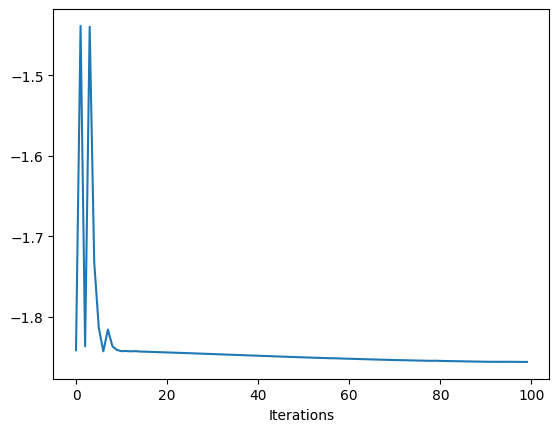

Schmidt Coefficients:


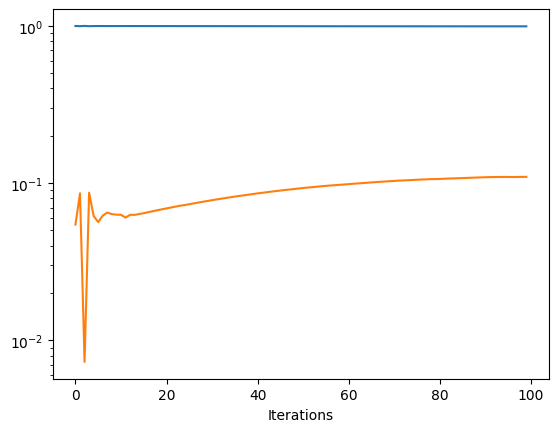

Parameters:


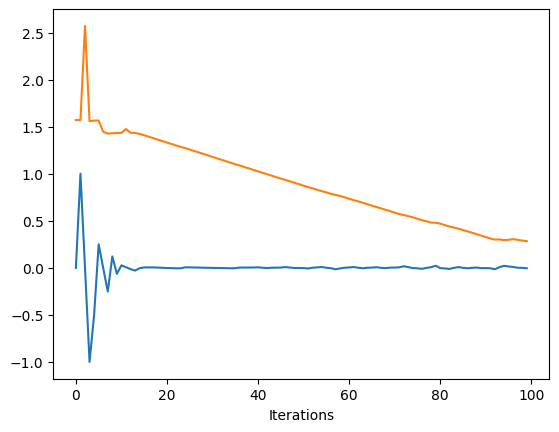

In [8]:
print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table

### This code is a Qiskit project.

© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.